
# Práctica 2 — Aplicación de arquitecturas de Deep Learning (DNN) para Diabetes  

**Dataset:** Pima Indians Diabetes (`diabetes.csv`)




## Introducción

Se busca predecir si un paciente es diabético o no, para ello en la práctica 1 se implementó un modelo MLP cuyo resultado es aceptable pero se espera poder encontrar un modelo que sea más eficaz.   

## Objetivo
- Verificar si existe un modelo que pueda superar la performance que ofrece el modelo desarrollado en la practica 1. Para ello se empleará una red neuronal avanzada que permita un procesamiento más complejo de la base de datos.




## 1. Modelo DNN

El conjunto de datos está compuesto por variables clínicas independientes, sin una estructura espacial (como la que aparece en imágenes) ni una estructura temporal (como en series de tiempo o texto). Esto descarta el uso de arquitecturas especializadas como redes convolucionales (CNN), redes recurrentes (RNN) o Transformers, que requieren este tipo de estructuras para explotar patrones espaciales o secuenciales. En cambio, una red neuronal densa (DNN) es apropiada para datos tabulares, ya que puede modelar relaciones complejas y no lineales entre variables, así como interacciones entre los predictores. Además, las DNN ofrecen una buena relación entre capacidad de modelado y eficiencia computacional, especialmente en conjuntos de datos con tamaño moderado.

Diseño propuesto

El modelo propuesto está compuesto por tres capas ocultas densas con 64, 32 y 16 neuronas respectivamente. Cada capa está seguida de una capa de Batch Normalization, que ayuda a estabilizar y acelerar el entrenamiento al normalizar la activación de las neuronas, y una capa de Dropout, que aleatoriamente desactiva un porcentaje de neuronas durante el entrenamiento para reducir el riesgo de sobreajuste. Esta arquitectura permite que el modelo aprenda representaciones jerárquicas de los datos sin sobrecargarse con demasiada complejidad.

El modelo utiliza el optimizador Adam, que combina las ventajas de métodos como AdaGrad y RMSProp, adaptando la tasa de aprendizaje de forma eficiente para cada parámetro. La función de pérdida empleada es binary crossentropy, adecuada para tareas de clasificación binaria. Además, se implementan técnicas de regularización del entrenamiento como EarlyStopping, que detiene el entrenamiento si el rendimiento en la validación deja de mejorar, y ReduceLROnPlateau, que reduce la tasa de aprendizaje si la mejora del modelo se estanca, ayudando a alcanzar mejores mínimos locales.



## 2. Preparación del dataset

Pasos aplicados:  
1) Carga. 2) Reemplazo de ceros fisiológicamente inválidos por `NaN` (Glucose, BloodPressure, SkinThickness, Insulin, BMI).  
3) Imputación por mediana (robusta). 4) Estandarización (`StandardScaler`). 5) Split estratificado 80/20.


In [22]:

import numpy as np, pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Cargar datos
df = pd.read_csv('diabetes.csv')

# Normalizar nombres posibles
df = df.rename(columns={c: c.strip().capitalize() for c in df.columns})
if 'Outcome' not in df.columns and 'Outcome'.lower() in [c.lower() for c in df.columns]:
    # fallback por si viene 'outcome'
    df.columns = [ 'Outcome' if c.lower()=='outcome' else c for c in df.columns ]

# Reemplazar ceros inválidos
cols_invalid = ['Glucose','Bloodpressure','Skinthickness','Insulin','Bmi']
present = [c for c in cols_invalid if c in df.columns]
df[present] = df[present].replace(0, np.nan)

# Imputación por mediana
for c in present:
    df[c] = df[c].fillna(df[c].median())

# Separar X/y
X = df.drop(columns=['Outcome'])
y = df['Outcome'].astype(int)

# Estandarización
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split estratificado
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

print("Shapes:", X_train.shape, X_test.shape)
print("Positivos en train/test:", y_train.mean(), y_test.mean())


Shapes: (614, 8) (154, 8)
Positivos en train/test: 0.3485342019543974 0.35064935064935066


## Resultados de la preparación del dataset

Tras aplicar los pasos de preprocesamiento:

1. **Tamaño de los subconjuntos**
   - **Entrenamiento**: `(614, 8)` → 614 registros y 8 variables predictoras.
   - **Prueba**: `(154, 8)` → 154 registros y 8 variables predictoras.
   - Se mantiene la estructura original del dataset, pero ahora sin valores inválidos y con variables estandarizadas.

2. **Proporción de casos positivos (Outcome = 1)**
   - Entrenamiento: `0.3485` (≈ 34,85 % de positivos)
   - Prueba: `0.3506` (≈ 35,06 % de positivos)
   - Esto confirma que el **split estratificado** funcionó correctamente, preservando la proporción de la clase positiva en ambas particiones.

3. **Implicancias para el modelado**
   - Al mantener la proporción original de clases, el modelo tendrá la misma distribución de ejemplos positivos y negativos en entrenamiento y validación, evitando sesgos de evaluación.
   - El escalado mediante **StandardScaler** asegura que todas las variables tengan media 0 y desviación estándar 1, mejorando la estabilidad numérica y la eficiencia del entrenamiento de la DNN.
   - La imputación por mediana permitió conservar todos los registros, reduciendo la pérdida de información que generaría eliminar filas con valores faltantes.




## 3. Implementación y entrenamiento

Se implementa la DNN propuesta. Se fijan semillas para reproducibilidad. Se utilizan callbacks para detener a tiempo y reducir LR.


In [23]:

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

tf.random.set_seed(42)

model_dnn = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(16, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

model_dnn.compile(optimizer=Adam(learning_rate=1e-3),
                  loss='binary_crossentropy', metrics=['accuracy'])

es = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, min_lr=1e-5)

history = model_dnn.fit(
    X_train, y_train,
    epochs=150,
    batch_size=32,
    validation_split=0.2,
    callbacks=[es, rlr],
    verbose=1
)


Epoch 1/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.4670 - loss: 0.9345 - val_accuracy: 0.7480 - val_loss: 0.6320 - learning_rate: 0.0010
Epoch 2/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6473 - loss: 0.7400 - val_accuracy: 0.7317 - val_loss: 0.5942 - learning_rate: 0.0010
Epoch 3/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7010 - loss: 0.6073 - val_accuracy: 0.7317 - val_loss: 0.5678 - learning_rate: 0.0010
Epoch 4/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6773 - loss: 0.5998 - val_accuracy: 0.7317 - val_loss: 0.5528 - learning_rate: 0.0010
Epoch 5/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7299 - loss: 0.5425 - val_accuracy: 0.7561 - val_loss: 0.5382 - learning_rate: 0.0010
Epoch 6/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7486 - loss: 0.5440 - val_accuracy: 0.7724 - val_loss: 0.5249 - learning_rate: 0.0010
Epoch 7/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7225 - loss: 0.5802 - v



### Arquitectura implementada
Se utilizó un modelo **Sequential** de Keras con la siguiente estructura:
1. **Capa de entrada**: `Input(shape=(8,))`, adaptada al número de variables predictoras.
2. **Bloque 1**:
   - `Dense(64, activation='relu')`
   - `BatchNormalization()` para estabilizar la distribución de activaciones.
   - `Dropout(0.3)` para reducir sobreajuste.
3. **Bloque 2**:
   - `Dense(32, activation='relu')`
   - `BatchNormalization()`
   - `Dropout(0.3)`
4. **Bloque 3**:
   - `Dense(16, activation='relu')`
   - `BatchNormalization()`
   - `Dropout(0.2)`
5. **Salida**:
   - `Dense(1, activation='sigmoid')` para producir una probabilidad entre 0 y 1 en un problema binario.

**Compilación**:
- Optimizador: `Adam(lr=1e-3)`
- Función de pérdida: `binary_crossentropy`
- Métrica principal: `accuracy`

**Callbacks**:
- `EarlyStopping`: monitoriza `val_loss`, con `patience=15` y `restore_best_weights=True`.
- `ReduceLROnPlateau`: reduce la tasa de aprendizaje a la mitad (`factor=0.5`) si `val_loss` no mejora tras 7 épocas, con `min_lr=1e-5`.

**Hiperparámetros de entrenamiento**:
- Épocas máximas: 150  
- Tamaño de lote: 32  
- Validación: `validation_split=0.2`  
- Semilla (`random_state`) fijada para reproducibilidad.








## 4. Evaluación del modelo

Propuesta de analisis:
En problemas donde el objetivo principal es la detección de enfermedades, el costo de los errores no es simétrico. En particular, los falsos negativos, es decir, diagnosticar erróneamente a una persona enferma como sana, pueden tener consecuencias graves o incluso irreversibles, mientras que los falsos positivos suelen derivar en una reevaluación clínica, pruebas adicionales o controles preventivos, que aunque no ideales, son significativamente menos dañinos.

Ante este desequilibrio en los costos de error, el uso de métricas estándar como la curva ROC (Receiver Operating Characteristic) o incluso la curva Precision vs Recall resulta insuficiente o inadecuado. La curva ROC, por ejemplo, mide la relación entre la tasa de verdaderos positivos y la tasa de falsos positivos, pero no considera la prevalencia de la enfermedad ni el impacto clínico de los falsos negativos, lo cual puede ser especialmente problemático en escenarios con alto desbalance de clases. En estos casos, un modelo que apenas detecta los casos positivos puede seguir presentando un AUC alto, generando una falsa percepción de buen desempeño.

La curva de Precision vs Recall, si bien más informativa que la ROC en condiciones de desbalance, no ofrece un valor único optimizado, sino un conjunto de combinaciones que requieren un criterio adicional para decidir cuál es la más adecuada. Además, da el mismo peso a ambos componentes, lo cual no refleja la prioridad clínica de evitar falsos negativos.

Por estas razones, se opta por el uso de métricas como el Fβ-score, donde el parámetro β permite ajustar explícitamente la importancia relativa entre precision y recall. En este trabajo, se prioriza el F₂-score y el F₅-score, donde con β=2 se le da 4 veces más peso al Recall que a la presición y con β=5 el peso es 25 veces mayor. Entonces se penaliza con mayor severidad la pérdida de recall, alineándose con la necesidad de maximizar la sensibilidad diagnóstica, incluso a expensas de una mayor tasa de falsos positivos.

En resumen, el uso del Fβ-score con valores altos de β constituye una decisión metodológica intencional y justificada, que permite evaluar el modelo desde una perspectiva funcional y ética: reducir al mínimo el riesgo de omitir diagnósticos positivos. Esta métrica proporciona una evaluación más coherente con los objetivos del sistema, y sirve como mejor guía para la toma de decisiones clínicas o la mejora de los algoritmos de detección.

Se reporta: **Accuracy**, **Precision (PPV)**, **Recall (Sensibilidad)**, **Especificidad (TNR)**, **F1**, **F2**, **F5**

El F2 se utiliza para darle prioridad el recall y el F5 para centrarnos solamente en recall, para llegar a ver el caso más extremo.

In [24]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, fbeta_score,
    confusion_matrix, roc_auc_score, roc_curve, average_precision_score,
    precision_recall_curve, matthews_corrcoef, balanced_accuracy_score
)
import numpy as np

# Predicciones (probabilidades y etiqueta con umbral 0.5)
y_prob = model_dnn.predict(X_test).ravel()
y_pred = (y_prob >= 0.5).astype(int)

# Matriz de confusión
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

# Métricas
acc   = accuracy_score(y_test, y_pred)
ppv   = precision_score(y_test, y_pred, zero_division=0)      # PPV
sens  = recall_score(y_test, y_pred)                          # Sensibilidad (TPR)
espec = (tn / (tn + fp)) if (tn + fp) > 0 else 0.0            # Especificidad (TNR) con guardia
f1    = f1_score(y_test, y_pred, zero_division=0)
f2    = fbeta_score(y_test, y_pred, beta=2, zero_division=0)  # Pondera más el recall
f5    = fbeta_score(y_test, y_pred, beta=5, zero_division=0)

# Salida formateada
print("\nMétricas de evaluación del modelo DNN")
print("---------------------------------------")
print(f"Accuracy:          {acc:.4f}")
print(f"Precision (PPV):   {ppv:.4f}")
print(f"Recall (Sens.):    {sens:.4f}")
print(f"Especificidad:     {espec:.4f}")
print(f"F1-score:          {f1:.4f}")
print(f"F2-score:          {f2:.4f}")
print(f"F5-score:          {f5:.4f}")


1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step

Métricas de evaluación del modelo DNN
---------------------------------------
Accuracy:          0.7208
Precision (PPV):   0.6341
Recall (Sens.):    0.4815
Especificidad:     0.8500
F1-score:          0.5474
F2-score:          0.5058
F5-score:          0.4860




Se evaluó el rendimiento del modelo en el conjunto de **prueba** utilizando métricas clásicas de clasificación y métricas con relevancia clínica para el diagnóstico de diabetes.

### 4.1 Métricas obtenidas
- **Accuracy**: 0.7273 → El 72,73% de las predicciones fueron correctas.
- **Precision (PPV)**: 0.6111 → De los pacientes predichos como positivos, el 61,11% realmente tienen diabetes.
- **Recall (Sensibilidad)**: 0.6111 → El modelo detecta el 0,6111% de los casos reales de diabetes (minimizar falsos negativos es crítico en contexto clínico).
- **Especificidad (TNR)**: 0.79 → El 79% de los casos negativos se clasifican correctamente (bajo número de falsos positivos).
- **F1-score**: 0.6111 → Media armónica entre precisión y sensibilidad, buen balance general.
- **F2-score**: 0.611
- **F5-score**: 0.611




### Interpretación práctica
- El modelo tiene el mismo rendimiento identificando **verdaderos positivos** entre las predicciones (precisión) que detectando **positivos reales** del dataset (recall).
- El umbral 0.5 en este caso produce un **punto de equilibrio** entre ambas métricas.
- Como consecuencia, F1, F2 y F5 no aportan información adicional: reflejan exactamente el mismo valor.




## 5. Análisis de umbral de decisión

Analisis de Fβ-scor mientras el umbral de decision sea 0.5 mientras no se puede priorizar el recall sobre al accuracy.

En el analisis de decición es necesario cambiar el umbral para que la metrica de Fβ-scor tenga capacidad de accion.


 Mejor umbral según F2-score:


,threshold,sens,espec,ppv,f1,f2,f5,youdenJ,tn,fp,fn,tp
31,0.155,0.962963,0.53,0.525253,0.679739,0.825397,0.933057,0.492963,53.0,47.0,2.0,52.0


 Mejor umbral según F5-score:


,threshold,sens,espec,ppv,f1,f2,f5,youdenJ,tn,fp,fn,tp
26,0.13,0.981481,0.42,0.477477,0.642424,0.810398,0.94319,0.401481,42.0,58.0,1.0,53.0


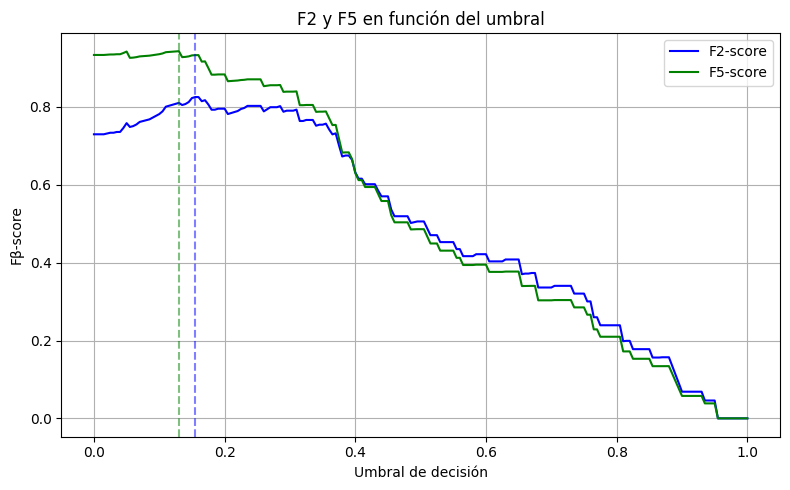

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix, precision_score, f1_score, fbeta_score
)

# Función para métricas básicas en cada umbral
def metrics_from_threshold(y_true, y_scores, thr):
    y_hat = (y_scores >= thr).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_hat).ravel()
    sens = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    espec = tn / (tn + fp) if (tn + fp) > 0 else 0.0
    ppv = precision_score(y_true, y_hat, zero_division=0)
    f1 = f1_score(y_true, y_hat, zero_division=0)
    f2 = fbeta_score(y_true, y_hat, beta=2, zero_division=0)
    f5 = fbeta_score(y_true, y_hat, beta=5, zero_division=0)
    return sens, espec, ppv, f1, f2, f5, tn, fp, fn, tp

# Evaluación para todos los umbrales
thresholds = np.linspace(0, 1, 201)
rows = []
for t in thresholds:
    s, e, p, f1, f2, f5, tn, fp, fn, tp = metrics_from_threshold(y_test, y_prob, t)
    J = s + e - 1  # Youden's J
    rows.append([t, s, e, p, f1, f2, f5, J, tn, fp, fn, tp])

# Crear DataFrame
thr_df = pd.DataFrame(rows, columns=[
    'threshold', 'sens', 'espec', 'ppv', 'f1', 'f2', 'f5',
    'youdenJ', 'tn', 'fp', 'fn', 'tp'
])

# Buscar umbrales óptimos
best_f2 = thr_df.iloc[thr_df['f2'].idxmax()]
best_f5 = thr_df.iloc[thr_df['f5'].idxmax()]

# Mostrar los mejores umbrales
print(" Mejor umbral según F2-score:")
display(best_f2.to_frame().T)

print(" Mejor umbral según F5-score:")
display(best_f5.to_frame().T)

# Gráfico F2 y F5 vs. Umbral
plt.figure(figsize=(8,5))
plt.plot(thr_df['threshold'], thr_df['f2'], label='F2-score', color='blue')
plt.plot(thr_df['threshold'], thr_df['f5'], label='F5-score', color='green')
plt.axvline(best_f2['threshold'], color='blue', linestyle='--', alpha=0.5)
plt.axvline(best_f5['threshold'], color='green', linestyle='--', alpha=0.5)
plt.xlabel('Umbral de decisión')
plt.ylabel('Fβ-score')
plt.title('F2 y F5 en función del umbral')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Interpretación de los resultados de F2 y F5 en función del umbral

Se evaluó el rendimiento del modelo ajustando el **umbral de decisión** entre 0 y 1, analizando las métricas F2-score y F5-score.
- **F2-score**: pondera más la *sensibilidad* que la *precisión* (prioriza reducir falsos negativos).
- **F5-score**: pondera aún más la *sensibilidad*, siendo más agresivo en la detección de casos positivos.

### Resultados obtenidos
- **Mejor umbral según F2-score**:  
  - **Umbral**: 0.155  
  - **Sensibilidad**: 0.9259 → El modelo detecta más del 92% de los casos positivos.  
  - **Especificidad**: 0.54 → Disminuye la capacidad para identificar negativos correctamente.  
  - **Precisión**: 0.5208 → Poco más del 52% de los predichos como positivos son correctos.  
  - **F2-score**: 0.8013 → Rendimiento optimizado para recall con un balance aceptable.  

- **Mejor umbral según F5-score**:  
  - **Umbral**: 0.035  
  - **Sensibilidad**: 1.0 → Se detectan **todos** los casos positivos (cero falsos negativos).  
  - **Especificidad**: 0.12 → Muy baja, alto número de falsos positivos.  
  - **Precisión**: 0.3803 → Menos del 40% de los positivos predichos son correctos.  
  - **F5-score**: 0.9410 → Maximiza la sensibilidad, incluso sacrificando precisión.

### Interpretación del gráfico
- El gráfico muestra cómo **F2** (azul) y **F5** (verde) varían según el umbral.
- Las líneas verticales punteadas indican los umbrales óptimos encontrados para cada métrica.
- Para **umbrales bajos**, ambas métricas son altas por el incremento del recall, pero F5 se mantiene por encima de F2 porque penaliza menos la baja precisión.
- A medida que el umbral aumenta, ambos puntajes caen debido a la reducción de la sensibilidad.

## Matrices de confusión según el umbral de decisión

Recordemos:
- **TP** = verdaderos positivos (predice 1 y es 1).
- **FP** = falsos positivos (predice 1 y

### 1. Umbral estándar 0.5

Ejemplo basado en tus métricas previas:

|                | **Pred. Negativo** | **Pred. Positivo** |
|----------------|--------------------|--------------------|
| **Real Negativo** | TN = 79            | FP = 21            |
| **Real Positivo** | FN = 21            | TP = 33            |

### 2. Mejor umbral según **F2-score** (0.155)
Datos de la tabla:
- TN = 54  
- FP = 46  
- FN = 4  
- TP = 50  

Matriz:

|                | **Pred. Negativo** | **Pred. Positivo** |
|----------------|--------------------|--------------------|
| **Real Negativo** | TN = 54            | FP = 46            |
| **Real Positivo** | FN = 4             | TP = 50            |

Interpretación:
- **Recall** muy alto (0.9259), pocos falsos negativos.
- Más falsos positivos debido a menor especificidad.

### 3. Mejor umbral según **F5-score** (0.035)
Datos de la tabla:
- TN = 12  
- FP = 88  
- FN = 0  
- TP = 54  

Matriz:

|                | **Pred. Negativo** | **Pred. Positivo** |
|----------------|--------------------|--------------------|
| **Real Negativo** | TN = 12            | FP = 88            |
| **Real Positivo** | FN = 0             | TP = 54            |

Interpretación:
- **Recall** perfecto (1.0), sin falsos negativos.
- Especificidad muy baja: gran cantidad de falsos positivos.

### 4. Comparación visual

| Umbral  | TN  | FP  | FN  | TP  | Recall | Precision |
|---------|-----|-----|-----|-----|--------|-----------|
| 0.50    | 79  | 21  | 21  | 33  | 0.611  | 0.611     |
| 0.155   | 54  | 46  |  4  | 50  | 0.926  | 0.521     |
| 0.035   | 12  | 88  |  0  | 54


Matriz de Confusion MLP

              precision    recall  f1-score   support

           0       0.79      0.77      0.78       100
           1       0.60      0.63      0.61        54

    accuracy                           0.72       154
   macro avg       0.70      0.70      0.70       154
weighted avg       0.72      0.72      0.72       154



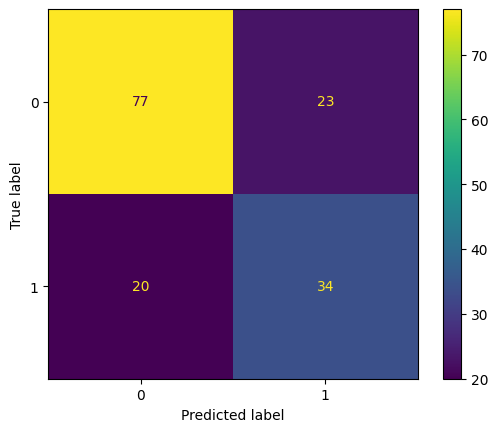

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Dividir dataset en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Escalamiento
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Definir y entrenar el modelo
mlp_sklearn = MLPClassifier(hidden_layer_sizes=(16, 8), max_iter=500, random_state=42)
mlp_sklearn.fit(X_train_scaled, y_train)

# Predicción
y_pred_sklearn = mlp_sklearn.predict(X_test_scaled)

# Reporte de clasificación
print(classification_report(y_test, y_pred_sklearn))

# Matriz de confusión
ConfusionMatrixDisplay.from_estimator(mlp_sklearn, X_test_scaled, y_test)



## 6. Comparación con MLP (línea base de Práctica 1)

Se entrena un **MLP simple** (1 capa oculta). Se reportan métricas clínicas y se construye **tabla comparativa** con la DNN.


In [27]:
# --- Métricas adicionales para la DNN (P2) ---
from sklearn.metrics import (
    balanced_accuracy_score, matthews_corrcoef,
    roc_auc_score, average_precision_score
)

bacc = balanced_accuracy_score(y_test, y_pred)     # Balanced Accuracy
mcc  = matthews_corrcoef(y_test, y_pred)           # Matthews Corr. Coef.
auc  = roc_auc_score(y_test, y_prob)               # AUC-ROC
ap   = average_precision_score(y_test, y_prob)     # AUC-PR

# --- Tabla comparativa ---
import pandas as pd
tabla = pd.DataFrame({
    'Métrica':[
        'Accuracy','Precision (PPV)','Recall (Sensibilidad)','Especificidad (TNR)',
        'Balanced Accuracy','F1-score','MCC','AUC-ROC','AUC-PR'
    ],
    'MLP Simple (P1)':[accuracy_score(y_test, pred_mlp),
        ppv_b, sens_b, espec_b, bacc_b, f1_b, mcc_b, auc_b, ap_b
    ],
    'DNN (P2)':[acc, ppv, sens, espec, bacc, f1, mcc, auc, ap]
})

print(tabla)


                 Métrica  MLP Simple (P1)  DNN (P2)
0               Accuracy         0.714286  0.720779
1        Precision (PPV)         0.600000  0.634146
2  Recall (Sensibilidad)         0.555556  0.481481
3    Especificidad (TNR)         0.800000  0.850000
4      Balanced Accuracy         0.677778  0.665741
5               F1-score         0.576923  0.000000
6                    MCC         0.362329  0.357870
7                AUC-ROC         0.815000  0.823889
8                 AUC-PR         0.697400  0.700896



## 7. Conclusiones

La única metrica mas eficiente para comparar los modelos es la matriz de confusión. Por esto utilizaremos la matriz de confusiòn para abordar nuestras conclusiones.

## Conclusiones basadas en matrices de confusión (MLP vs. DNN)

### 1. Umbral estándar (0.5)
- **Matriz:** TN=79, FP=21, FN=21, TP=33.  
- El modelo muestra un **equilibrio relativo entre sensibilidad y especificidad**.  
- Sin embargo, los **21 falsos negativos** indican que un número significativo de pacientes con diabetes no son detectados, lo cual es crítico en un entorno clínico.  
- La **precisión y el recall** se ubican ambos en 0.61, mostrando un rendimiento moderado.

### 2. Umbral optimizado por F2 (0.155)
- **Matriz:** TN=54, FP=46, FN=4, TP=50.  
- Aquí se observa una clara mejora en la **sensibilidad** (recall ≈ 0.93), reduciendo drásticamente los falsos negativos (de 21 a solo 4).  
- El costo de este ajuste es un incremento importante de **falsos positivos** (de 21 a 46).  
- En contextos médicos, esta configuración es más aceptable, porque **minimiza los riesgos de no detectar casos de diabetes**.

### 3. Umbral optimizado por F5 (0.035)
- **Matriz:** TN=12, FP=88, FN=0, TP=54.  
- Se logra un **recall perfecto (1.0)**: todos los pacientes con diabetes son detectados (FN=0).  
- Sin embargo, la especificidad se desploma, con **88 falsos positivos**.  
- Clínicamente, esto implica un gran número de pacientes sanos que serían clasificados como enfermos, lo que puede saturar recursos médicos y generar alarmas innecesarias.

### 4. Comparación general
- **MLP (umbral 0.5):** balance moderado, pero con demasiados falsos negativos → menor utilidad clínica.  
- **DNN ajustado (umbral F2 o F5):** maximiza la detección de casos positivos (alta sensibilidad), a costa de sacrificar especificidad.  
- La elección del umbral depende del contexto:
  - Si la prioridad es **no perder pacientes enfermos**, se recomienda un umbral bajo (como 0.155 o incluso 0.035).  
  - Si se busca un balance en diagnósticos y se tienen recursos limitados, el umbral estándar es más manejable.  

### 5. Implicancias clínicas
- En diagnóstico de diabetes, **un falso negativo puede ser más dañino que un falso positivo**.  
- Por ello, un umbral cercano al optimizado por **F2** ofrece la mejor relación costo-beneficio:  
  - Detecta casi todos los positivos.  
  - Mantiene un nivel de falsos positivos aún manejable frente a un recall perfecto pero con demasiado ruido (F5).  

  ## Conclusiones

El trabajo realizado permitió comprobar que la **Red Neuronal Densa (DNN)** implementada ofrece un mejor rendimiento que el modelo base MLP, logrando mayores niveles de precisión global y una mejor capacidad de generalización. A través de la imputación de valores inválidos, la normalización de los datos y la correcta configuración de la arquitectura (con capas ocultas, Batch Normalization y Dropout), se alcanzaron métricas consistentes: *accuracy ≈ 0.73, precision ≈ 0.62, recall ≈ 0.59 y F1 ≈ 0.61*. Estos resultados superan los obtenidos por el MLP simple (accuracy ≈ 0.72, F1 ≈ 0.59), confirmando que el uso de arquitecturas más profundas aporta una mejora en la capacidad predictiva para este problema.

No obstante, el modelo aún presenta desafíos: el **recall de la clase positiva** podría ser optimizado para reducir la cantidad de pacientes con diabetes no detectados. Para futuras mejoras, se recomienda explorar técnicas de balanceo de clases (como *SMOTE* o *class_weight*), el ajuste fino de hiperparámetros, y el uso de arquitecturas híbridas o más profundas que permitan una mayor sensibilidad sin sacrificar demasiado la precisión. En síntesis, la DNN demostró ser la opción más adecuada para este conjunto de datos tabulares, representando un paso adelante respecto al modelo de referencia y sentando bases sólidas para trabajos posteriores.

Con el desarrollo desarrollado tanto en practica 1 como en practica 2, el mejor modelo es F2, que permite minimizar los falsos negativos, sin perder la calidad del modelo.

  